# Interpolation with polynomials

In [1]:
# Define polynomial utilities (1D, square matrix)
import numpy as np
import sympy

def get_polynomial_matrix(interpolation_points: np.ndarray) -> np.ndarray:
    n_rows = n_cols = interpolation_points.shape[0]
    matrix = np.zeros(shape = (n_rows, n_cols))
    for col_index in range(n_cols):
        matrix[:, col_index] = interpolation_points ** col_index
    return matrix

def get_polynomial_interpolant(interpolation_points: np.ndarray, 
                               target_points: np.ndarray) -> sympy.Poly:
    matrix = get_polynomial_matrix(interpolation_points)
    coefs = np.linalg.solve(matrix, target_points)
    return sympy.Poly.from_list(np.flip(coefs), sympy.Symbol('x'))

In [2]:
import numpy as np


i = 24
x = np.linspace(0, 2, i)
y = np.exp(x)

print(np.linalg.cond(get_polynomial_matrix(x)))

2.8523270948584266e+20


In [3]:
# Get coefficients of polynomial interpolation
matrix = get_polynomial_matrix(x)
explicit_coefficients_lsq = np.linalg.solve(matrix, y) # a0, a1, a2, ..., aN
explicit_coefficients_inv = np.matmul(np.linalg.inv(matrix), y) # a0, a1, a2, ..., aN

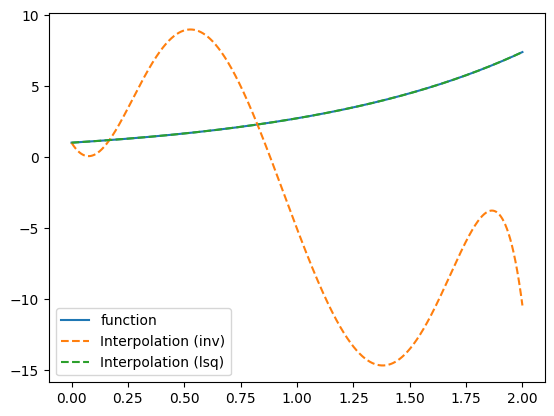

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x_np = np.linspace(0, 2, 15000)

y_interp_inv = sum(c * (x_np**i) for i, c in enumerate(explicit_coefficients_inv))
y_interp_lsq = sum(c * (x_np**i) for i, c in enumerate(explicit_coefficients_lsq))
plt.plot(x_np, np.exp(x_np), label = "function")
plt.plot(x_np, y_interp_inv, label="Interpolation (inv)", linestyle='--')
plt.plot(x_np, y_interp_lsq, label="Interpolation (lsq)", linestyle='--')
plt.legend()
plt.show()

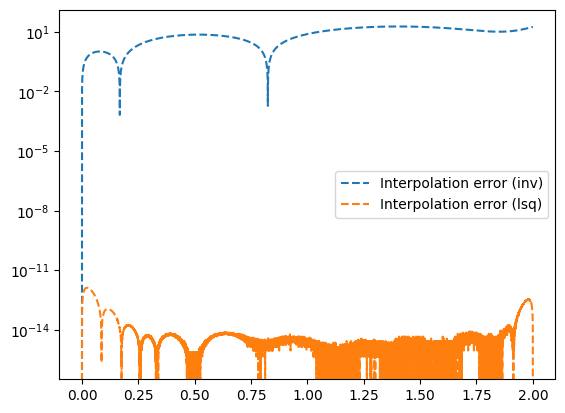

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x_np = np.linspace(0, 2, 15000)

y_interp_inv = sum(c * (x_np**i) for i, c in enumerate(explicit_coefficients_inv))
y_interp_lsq = sum(c * (x_np**i) for i, c in enumerate(explicit_coefficients_lsq))

plt.semilogy(x_np, np.abs(y_interp_inv - np.exp(x_np)), label="Interpolation error (inv)", linestyle='--')
plt.semilogy(x_np, np.abs(y_interp_lsq - np.exp(x_np)) , label="Interpolation error (lsq)", linestyle='--')
plt.legend()
plt.show()

# Interpolation with variational model

In [7]:
import torch

In [8]:
# Polynomial parameters
alphas = torch.nn.Parameter(torch.zeros(i))
alphas.shape

torch.Size([24])

In [9]:
x_torch = torch.tensor(x)
y_torch = torch.exp(x_torch)
print(x, y)

[0.         0.08695652 0.17391304 0.26086957 0.34782609 0.43478261
 0.52173913 0.60869565 0.69565217 0.7826087  0.86956522 0.95652174
 1.04347826 1.13043478 1.2173913  1.30434783 1.39130435 1.47826087
 1.56521739 1.65217391 1.73913043 1.82608696 1.91304348 2.        ] [1.         1.09084925 1.18995209 1.29805834 1.41598597 1.54462723
 1.68495546 1.8380324  2.00501627 2.18717049 2.38587329 2.60262809
 2.8390749  3.09700273 3.37836311 3.68528486 4.02009023 4.38531241
 4.78371476 5.21831166 5.69239136 6.20954085 6.77367299 7.3890561 ]


In [10]:
loss_list = []
alphas_progress = torch.zeros(1, i)

In [23]:
it = 1
optimizer = torch.optim.Adam([alphas], lr=1e-6)
while True:
    # Calculate polynomial values
    poly_values = sum(c * (x_torch**i) for i, c in enumerate(alphas))

    # Calculate loss (mean squared error)
    loss = torch.mean((poly_values - y_torch)**2)

    # Store loss and alphas
    loss_list += [loss.item()]
    alphas_progress = torch.cat((alphas_progress, torch.zeros(1, i)))
    alphas_progress[-1, :] = alphas

    # Update parameters
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f'{it} loss: {loss_list[-1]}', end='\r')
    if it % 100000 == 0:
        break
    it = it + 1
        

Text(0.5, 1.0, 'Loss function (log10), MSE')

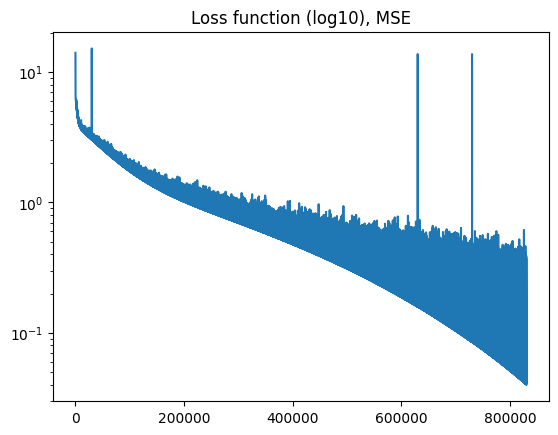

In [24]:
import numpy as np
import matplotlib.pyplot as plt

plt.semilogy(loss_list)
plt.title("Loss function (log10), MSE")
# print(loss_list[-1] / 5) # MEAN squared error

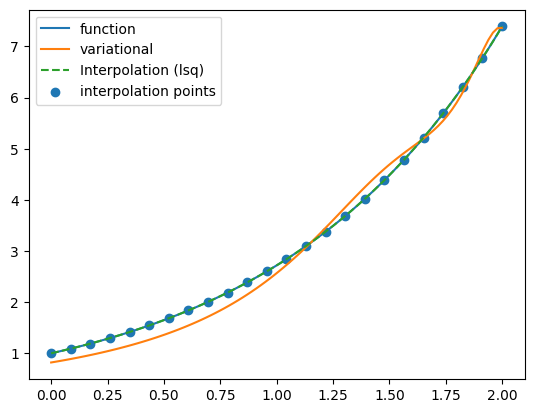

In [25]:
import numpy as np
import matplotlib.pyplot as plt

x_np = np.linspace(0, 2, 100)
plt.plot(x_np, np.exp(x_np), label = "function")

a = alphas.detach().numpy()
y_interp = sum(c * (x_np**i) for i, c in enumerate(a))
plt.plot(x_np, y_interp, label = "variational")

y_interp_lsq = sum(c * (x_np**i) for i, c in enumerate(explicit_coefficients_lsq))
plt.plot(x_np, y_interp_lsq, label="Interpolation (lsq)", linestyle='--')

# y_interp_inv = sum(c * (x_np**i) for i, c in enumerate(explicit_coefficients_inv))
# plt.plot(x_np, y_interp_inv, label="Interpolation (inv)", linestyle='--')

plt.scatter(x, y, label = "interpolation points")
plt.legend()

/tmp/ipykernel_10445/2899178245.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


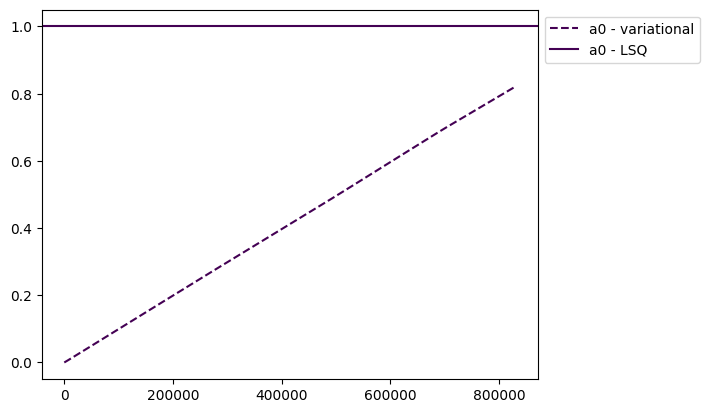

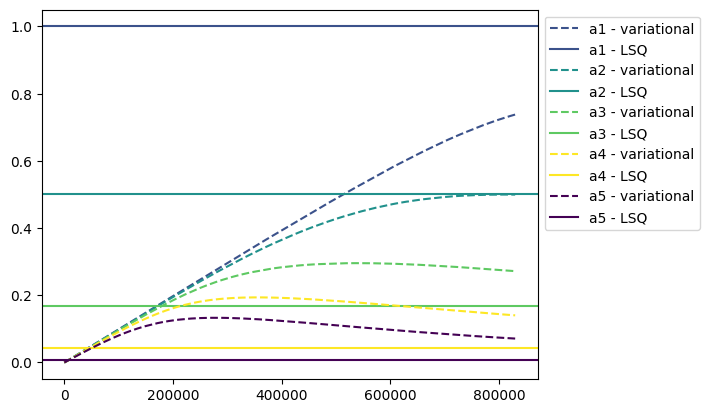

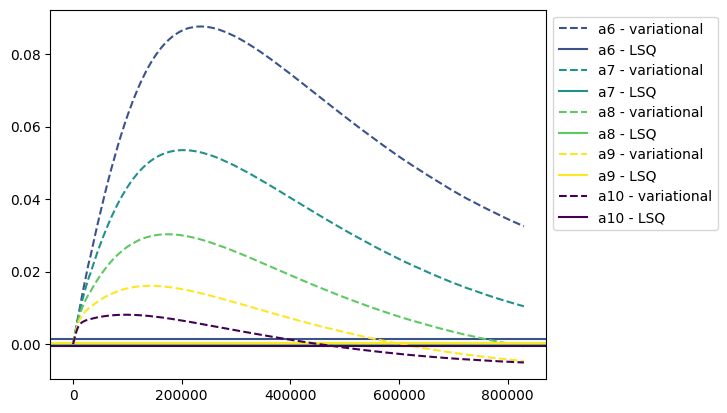

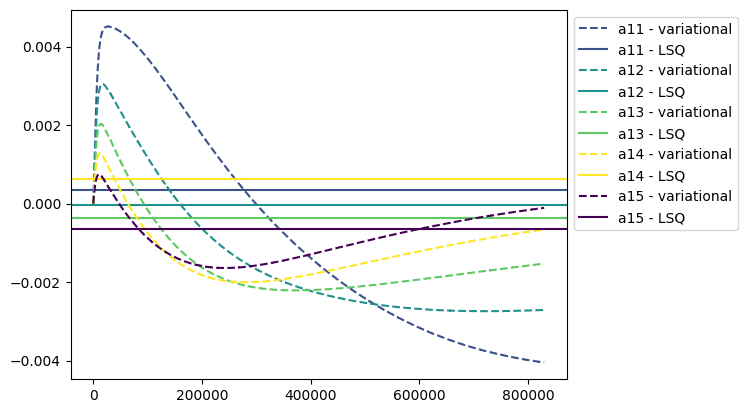

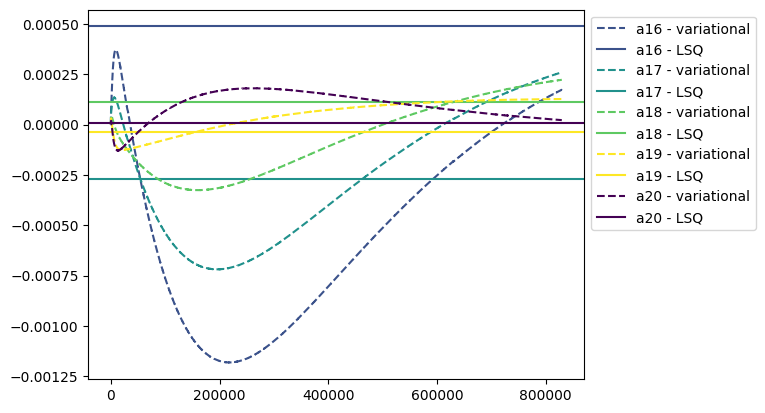

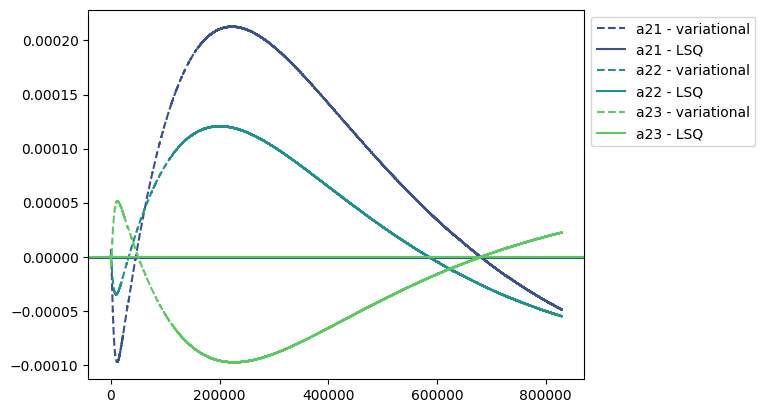

In [26]:
alphas_numpy = alphas_progress.detach().numpy()
# Get a colormap
cmap = plt.cm.get_cmap('viridis')

# Get 20 distinct colors from the colormap
colors = cmap(np.linspace(0, 1, 5))

for index in range(alphas_numpy.shape[1]):
    plt.plot(alphas_numpy[:, index], label=f"a{index} - variational", linestyle='--', color=colors[index % 5])
    plt.axhline(explicit_coefficients_lsq[index], label=f"a{index} - LSQ", color=colors[index % 5])
    if index % 5 == 0 or index == alphas_numpy.shape[1] - 1:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()

----

In [31]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Target points
x_target = torch.linspace(0, 2, 20)
y_target = torch.exp(x_target)

# Variables to optimize (polynomial coefficients)
coefficients = torch.nn.Parameter(torch.zeros(20, requires_grad=True))

# Optimizer
optimizer = optim.Adam([coefficients], lr=0.005)

# Number of optimization steps
num_steps = 30000

# Gradient descent
for step in range(num_steps):
    # Calculate polynomial values
    poly_values = sum(c * (x_target**i) for i, c in enumerate(coefficients))

    # Calculate loss (mean squared error)
    loss = torch.mean((poly_values - y_target)**2)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 1000 steps
    if step % 1000 == 0:
        print(f"Step {step}/{num_steps}, Loss: {loss.item()}")

# Get the optimized coefficients
optimized_coefficients = coefficients.detach()

# Create a polynomial using the optimized coefficients
# poly = torch.poly1d(optimized_coefficients.tolist())

# # Evaluate the polynomial at various points for visualization
# x_interp = torch.linspace(0, 2, 1000)
# y_interp = sum(c * (x_interp**i) for i, c in enumerate(optimized_coefficients))

# # Plotting
# plt.plot(x_target, y_target, 'o', label='Exponential Function')
# plt.plot(x_interp, y_interp, label='Optimized Polynomial')
# plt.title('Exponential Function and Polynomial Approximation using Gradient Descent')
# plt.legend()
# plt.show()


Step 0/30000, Loss: 14.166498184204102
Step 1000/30000, Loss: 2.7854866981506348
Step 2000/30000, Loss: 0.865607738494873
Step 3000/30000, Loss: 0.43319448828697205
Step 4000/30000, Loss: 0.214809387922287
Step 5000/30000, Loss: 2.1213297843933105
Step 6000/30000, Loss: 0.09355636686086655
Step 7000/30000, Loss: 59.06324005126953
Step 8000/30000, Loss: 0.0496942475438118
Step 9000/30000, Loss: 0.7859302163124084
Step 10000/30000, Loss: 0.2110484540462494
Step 11000/30000, Loss: 0.027527188882231712
Step 12000/30000, Loss: 18.98648452758789
Step 13000/30000, Loss: 0.022196318954229355
Step 14000/30000, Loss: 0.019900299608707428
Step 15000/30000, Loss: 482.39349365234375
Step 16000/30000, Loss: 0.01712712273001671
Step 17000/30000, Loss: 432.67669677734375
Step 18000/30000, Loss: 0.04101348668336868
Step 19000/30000, Loss: 0.014144005253911018
Step 20000/30000, Loss: 8.181427001953125
Step 21000/30000, Loss: 0.012630170211195946
Step 22000/30000, Loss: 0.011962844990193844
Step 23000/30

In [32]:
my_coefs = optimized_coefficients.detach().numpy()

In [33]:
x_interp = torch.linspace(0, 2, 1000)
y_interp = sum(c * (x_interp**i) for i, c in enumerate(my_coefs))

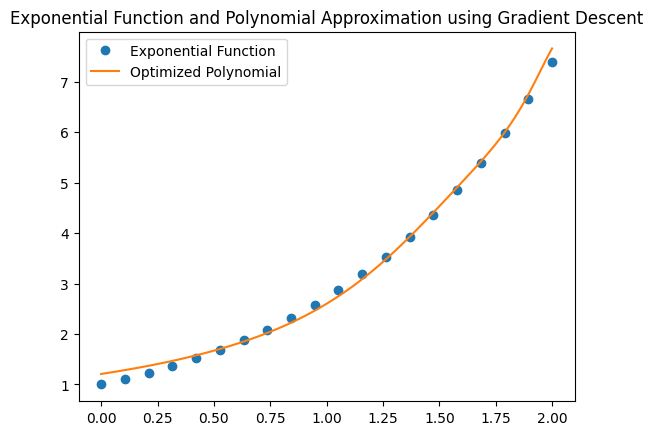

In [34]:
plt.plot(x_target, y_target, 'o', label='Exponential Function')
plt.plot(x_interp, y_interp, label='Optimized Polynomial')
plt.title('Exponential Function and Polynomial Approximation using Gradient Descent')
plt.legend()
plt.show()